In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2

In [4]:
# Define dataset path
DATASET_PATH = "C:/Users/ayush/OneDrive/Desktop/Depression_Detection/CK+48"  # Change this to your dataset folder path
IMG_SIZE = 32  # Resize images to 32x32

# Load and preprocess dataset
def load_data(dataset_path):
    images = []
    labels = []
    class_names = os.listdir(dataset_path)
    class_map = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            images.append(image)
            labels.append(class_map[class_name])
    
    images = np.array(images) / 255.0  # Normalize
    labels = to_categorical(np.array(labels), len(class_names))
    return train_test_split(images, labels, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_data(DATASET_PATH)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)



In [5]:
# Simple CNN Model
def build_cnn():
    model = tf.keras.Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(y_train[0]), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# DSCN Model
def build_dscn():
    input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Small kernel branch
    branch1 = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    branch1 = MaxPooling2D((2,2))(branch1)
    branch1 = Conv2D(64, (3,3), activation='relu', padding='same')(branch1)
    branch1 = MaxPooling2D((2,2))(branch1)
    
    # Large kernel branch
    branch2 = Conv2D(32, (7,7), activation='relu', padding='same')(input_layer)
    branch2 = MaxPooling2D((2,2))(branch2)
    branch2 = Conv2D(64, (7,7), activation='relu', padding='same')(branch2)
    branch2 = MaxPooling2D((2,2))(branch2)
    
    # Concatenate features
    merged = Concatenate()([branch1, branch2])
    merged = Flatten()(merged)
    merged = Dense(512, activation='relu')(merged)
    merged = Dropout(0.5)(merged)
    output_layer = Dense(len(y_train[0]), activation='softmax')(merged)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2089 - loss: 1.9791 - val_accuracy: 0.2284 - val_loss: 1.8127
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2194 - loss: 1.8759 - val_accuracy: 0.2284 - val_loss: 1.7965
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2823 - loss: 1.7873 - val_accuracy: 0.3655 - val_loss: 1.7788
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2740 - loss: 1.8147 - val_accuracy: 0.3959 - val_loss: 1.7377
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3338 - loss: 1.7509 - val_accuracy: 0.3706 - val_loss: 1.6252
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3520 - loss: 1.6522 - val_accuracy: 0.4213 - val_loss: 1.5013
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3928 - loss: 1.5561 - val_accuracy: 0.4822 - val_loss: 1.4168
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4430 - loss: 1.4665 - val_accuracy: 0.4975 - v

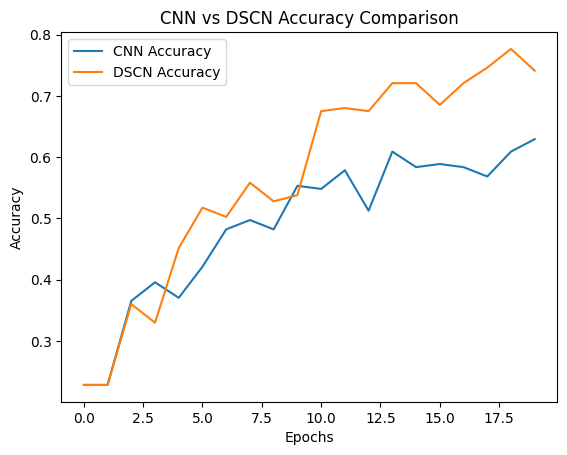

In [7]:
# Train both models
cnn_model = build_cnn()
dscn_model = build_dscn()

cnn_history = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=20, batch_size=32)
dscn_history = dscn_model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Compare Accuracy
cnn_acc = cnn_history.history['val_accuracy'][-1] * 100
dscn_acc = dscn_history.history['val_accuracy'][-1] * 100
print(f"CNN Validation Accuracy: {cnn_acc:.2f}%")
print(f"DSCN Validation Accuracy: {dscn_acc:.2f}%")

# Plot Accuracy
plt.plot(cnn_history.history['val_accuracy'], label='CNN Accuracy')
plt.plot(dscn_history.history['val_accuracy'], label='DSCN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('CNN vs DSCN Accuracy Comparison')
plt.show()
